# Mathmore Integration
Example on the  usage of the adaptive 1D integration algorithm of MathMore
it calculates the numerically cumulative integral of a distribution (like in this case the BreitWigner)
to execute the macro type it (you need to compile with AClic)

```cpp
root[0] .x mathmoreIntegration.C+
```

This tutorials require having libMathMore built with ROOT.

To build mathmore you need to have a version of GSL >= 1.8 installed in your system
The ROOT configure will automatically find GSL if the script gsl-config (from GSL) is in your PATH,.
otherwise you need to configure root with the options --gsl-incdir and --gsl-libdir.




**Author:**  M. Slawinska, L. Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 02:11 AM.</small></i>

In [1]:
%%cpp -d
#include "TMath.h"
#include "TH1.h"
#include "TCanvas.h"
#include "TLegend.h"

/*#include "TLabel.h"*/
#include "Math/Functor.h"
#include "Math/WrappedFunction.h"
#include "Math/IFunction.h"
#include "Math/Integrator.h"
#include <iostream>

#include "TStopwatch.h"
#include "TF1.h"

#include <limits>

!calculates exact integral of breit wigner distribution
!and compares with existing methods

In [2]:
int nc = 0;

 A helper function is created: 

In [3]:
%%cpp -d
double exactIntegral( double a, double b) {

  return (TMath::ATan(2*b)- TMath::ATan(2*a))/ TMath::Pi();
}

 A helper function is created: 

In [4]:
%%cpp -d
double func( double x){
   nc++;
   return TMath::BreitWigner(x);
}

  TF1 requires the function to have the ( )( double *, double *) signature
 

In [5]:
%%cpp -d
double func2(const double *x, const double * = 0){
   nc++;
   return TMath::BreitWigner(x[0]);
}

 A helper function is created: 

In [6]:
%%cpp -d
void  testIntegPerf(double x1, double x2, int n = 100000){


   std::cout << "\n\n***************************************************************\n";
   std::cout << "Test integration performances in interval [ " << x1 << " , " << x2 << " ]\n\n";

  TStopwatch timer;

  double dx = (x2-x1)/double(n);

  //ROOT::Math::Functor1D<ROOT::Math::IGenFunction> f1(& TMath::BreitWigner);
  ROOT::Math::WrappedFunction<> f1(func);

  timer.Start();
  ROOT::Math::Integrator ig(f1 );
  double s1 = 0.0;
  nc = 0;
  for (int i = 0; i < n; ++i) {
     double x = x1 + dx*i;
     s1+= ig.Integral(x1,x);
  }
  timer.Stop();
  std::cout << "Time using ROOT::Math::Integrator        :\t" << timer.RealTime() << std::endl;
  std::cout << "Number of function calls = " << nc/n << std::endl;
  int pr = std::cout.precision(18);  std::cout << s1 << std::endl;  std::cout.precision(pr);



  //TF1 *fBW = new TF1("fBW","TMath::BreitWigner(x)",x1, x2);  //  this is faster but cannot measure number of function calls
  TF1 *fBW = new TF1("fBW",func2,x1, x2,0);

  timer.Start();
  nc = 0;
  double s2 = 0;
  for (int i = 0; i < n; ++i) {
     double x = x1 + dx*i;
     s2+= fBW->Integral(x1,x );
  }
  timer.Stop();
  std::cout << "Time using TF1::Integral :\t\t\t" << timer.RealTime() << std::endl;
  std::cout << "Number of function calls = " << nc/n << std::endl;
  pr = std::cout.precision(18);  std::cout << s1 << std::endl;  std::cout.precision(pr);


}

 A helper function is created: 

In [7]:
%%cpp -d
void  DrawCumulative(double x1, double x2, int n = 100){

   std::cout << "\n\n***************************************************************\n";
   std::cout << "Drawing cumulatives of BreitWigner in interval [ " << x1 << " , " << x2 << " ]\n\n";


   double dx = (x2-x1)/double(n);

   TH1D *cum0 = new TH1D("cum0", "", n, x1, x2); //exact cumulative
   for (int i = 1; i <= n; ++i) {
      double x = x1 + dx*i;
      cum0->SetBinContent(i, exactIntegral(x1, x));

   }

   // alternative method using ROOT::Math::Functor class
   ROOT::Math::Functor1D f1(& func);


   ROOT::Math::Integrator ig(f1, ROOT::Math::IntegrationOneDim::kADAPTIVE,1.E-12,1.E-12);

   TH1D *cum1 = new TH1D("cum1", "", n, x1, x2);
   for (int i = 1; i <= n; ++i) {
      double x = x1 + dx*i;
      cum1->SetBinContent(i, ig.Integral(x1,x));
   }


   TF1 *fBW = new TF1("fBW","TMath::BreitWigner(x, 0, 1)",x1, x2);


   TH1D *cum2 = new TH1D("cum2", "", n, x1, x2);
   for (int i = 1; i <= n; ++i) {
      double x = x1 + dx*i;
      cum2->SetBinContent(i, fBW->Integral(x1,x));
   }

   TH1D *cum10 = new TH1D("cum10", "", n, x1, x2); //difference between  1 and exact
   TH1D *cum20 = new TH1D("cum23", "", n, x1, x2); //difference between 2 and excact
   for (int i = 1; i <= n; ++i) {
      double delta  =  cum1->GetBinContent(i) - cum0->GetBinContent(i);
      double delta2 =  cum2->GetBinContent(i) - cum0->GetBinContent(i);
      //std::cout << " diff for " << x << " is " << delta << "  " << cum1->GetBinContent(i) << std::endl;
      cum10->SetBinContent(i, delta );
      cum10->SetBinError(i, std::numeric_limits<double>::epsilon() * cum1->GetBinContent(i) );
      cum20->SetBinContent(i, delta2 );
   }


   TCanvas *c1 = new TCanvas("c1","Integration example",20,10,800,500);
   c1->Divide(2,1);
   c1->Draw();

   cum0->SetLineColor(kBlack);
   cum0->SetTitle("BreitWigner - the cumulative");
   cum0->SetStats(0);
   cum1->SetLineStyle(2);
   cum2->SetLineStyle(3);
   cum1->SetLineColor(kBlue);
   cum2->SetLineColor(kRed);
   c1->cd(1);
   cum0->DrawCopy("h");
   cum1->DrawCopy("same");
   //cum2->DrawCopy("same");
   cum2->DrawCopy("same");

   c1->cd(2);
   cum10->SetTitle("Difference");
   cum10->SetStats(0);
   cum10->SetLineColor(kBlue);
   cum10->Draw("e0");
   cum20->SetLineColor(kRed);
   cum20->Draw("hsame");

   TLegend * l = new TLegend(0.11, 0.8, 0.7 ,0.89);
   l->AddEntry(cum10, "GSL integration - analytical ");
   l->AddEntry(cum20, "TF1::Integral  - analytical ");
   l->Draw();


   c1->Update();
   std::cout << "\n***************************************************************\n";


}

 Arguments are defined. 

In [8]:
double a = -2;
double b = 2;



***************************************************************
Drawing cumulatives of BreitWigner in interval [ -2 , 2 ]


***************************************************************


***************************************************************
Test integration performances in interval [ -2 , 2 ]

Time using ROOT::Math::Integrator        :	0.149756
Number of function calls = 69
42201.6649413923442


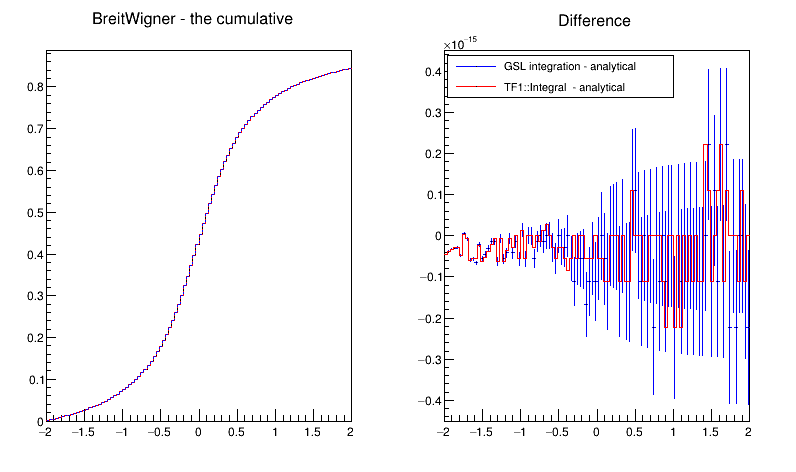

Time using TF1::Integral :			0.468895
Number of function calls = 91
42201.6649413923442


In [9]:
DrawCumulative(a, b);
testIntegPerf(a, b);